In [1]:
from SimPEG import Mesh, Utils, Maps, PF, Regularization, Optimization, Directives, DataMisfit, InvProblem, Inversion
from SimPEG.Utils import mkvc
import numpy as np
import scipy as sp
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [192]:
work_dir = 'C:\\Users\\DominiqueFournier\\ownCloud\\Research\\Synthetic\\Fold\\'
driver = PF.GravityDriver.GravityDriver_Inv(input_file=work_dir + 'SimPEG_GRAV.inp')
mesh = driver.mesh
# mesh = Mesh.TensorMesh.readUBC(work_dir+'Mesh_20m.msh')
model, ndv = Mesh.TensorMesh.readModelUBC(mesh,work_dir+'TopoFold.den'), -100
survey = driver.survey

topo = np.genfromtxt(work_dir + driver.topofile, skip_header=1)

In [138]:
# Create a sub-survey and sub-sample randomly
nD = survey.srcField.rxList[0].locs.shape[0]
nDsub = int(nD*0.25)

print("nD ratio:" + str(nDsub) +'\\' + str(nD) )
indx = np.random.randint(0, high=nD, size=nDsub)
# Create a new downsampled survey
locXYZ = survey.srcField.rxList[0].locs[indx,:]

dobs = survey.dobs
std = survey.std

rxLoc = PF.BaseGrav.RxObs(locXYZ)
srcField = PF.BaseMag.SrcField([rxLoc], param=survey.srcField.param)
survey = PF.BaseMag.LinearSurvey(srcField)
survey.dobs = dobs[indx]
survey.std = std[indx]



nD ratio:563\2255


In [139]:
# actv = driver.activeCells
# nC = len(actv)

# m = np.ones(mesh.nC)*-100
# m[actv] = model[actv]
# Mesh.TensorMesh.writeModelUBC(mesh,work_dir + 'TopoFold.den', m)

Begin calculation of forward operator: z
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



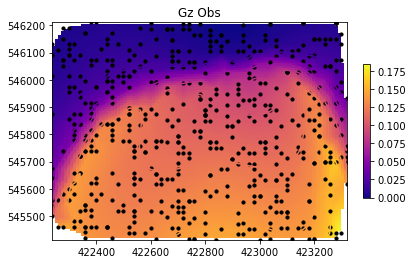

In [140]:
# Generate data
actv = driver.activeCells
nC = len(actv)

idenMap = Maps.IdentityMap(nP=nC)
prob = PF.Gravity.GravityIntegral(mesh, rhoMap = idenMap, actInd=actv)


survey.pair(prob)

data = prob.fields(model[actv]*1.5)

survey.dobs = data
survey.std = data**0.*1e-3
fig = PF.Gravity.plot_obs_2D(survey.srcField.rxList[0].locs,d=data)



In [154]:
PF.Gravity.writeUBCobs(work_dir + 'Grid_25m_Randn.obs',survey,  data)

Observation file saved to: C:\Users\DominiqueFournier\ownCloud\Research\Synthetic\Fold\Grid_25m_Randn.obs


In [123]:
from SimPEG.Utils import sdiag, speye, kron3
 

# Load in direction points
mk = np.loadtxt(work_dir + 'Structural_Markers.dat')
pts, dip, azm = mk[:,:3], mk[:,3], mk[:,4]

def Rz(theta):
    """Rotation matrix about z axis"""
    theta = np.deg2rad(theta)
    Rz = np.vstack((np.r_[np.cos((theta)),
                          -np.sin((theta)), 0],
                   np.r_[np.sin((theta)),
                         np.cos((theta)), 0],
                   np.r_[0, 0, 1]))
    return Rz
                          
def Ry(theta):
    """Rotation matrix about y axis"""
    theta = np.deg2rad(theta)
    Ry = np.vstack( (np.r_[np.cos((theta)), 0,
                     np.sin((theta))],
                   np.r_[0, 1, 0],
               np.r_[-np.sin((theta)), 0,
                     np.cos((theta))]))

    return Ry

rx = []

for ii in range(dip.shape[0]):
    
    
    rx += [np.dot(Rz(-azm[ii]),np.dot(Ry(dip[ii]),np.r_[0,0,1]))]

    
rx = np.asarray(rx)


In [129]:
# Interpolate dip/azm in 3D
mrx = Utils.modelutils.MinCurvatureInterp(mesh, pts, rx, tol=1e-5, iterMax=1000)
mout = sdiag(np.sum(mrx**2,axis=1)**-0.5) * mrx


amp = np.sum(mout**2,axis=1)**0.5
mout = sdiag(1./amp) * mout
mout[:,-1] *= -1

# Convert normals to rotation angles
nC = mesh.nC
atp = Utils.coordutils.xyz2atp(mout)

theta = atp[nC:2*nC]
phi = atp[2*nC:]



indActive = np.zeros(mesh.nC, dtype=bool)
indActive[actv] = True

Pac = Utils.speye(mesh.nC)[:, indActive]

Dx1, rx1 = getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X')
Dy1, ry1 = getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y')
Dz1, rz1 = getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z')

Dx1 = Pac.T * Dx1 * Pac
Dy1 = Pac.T * Dy1 * Pac
Dz1 = Pac.T * Dz1 * Pac


Dx2, rx2 = getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X', forward=False)
Dy2, ry2 = getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y', forward=False)
Dz2, rz2 = getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z', forward=False)

Dx2 = Pac.T * Dx2 * Pac
Dy2 = Pac.T * Dy2 * Pac
Dz2 = Pac.T * Dz2 * Pac


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


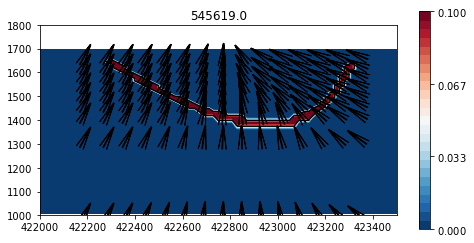

In [141]:
fig, axs = plt.figure(figsize=(8,8)), plt.subplot()
xlim=[422000,423500]#[545000, 546700]#
ylim=[1000,1800]
ind = 16
plotModelSections(mesh, model, normal='y', ind=ind,subFact=4, scale=3., cmap='RdBu_r', axs=axs,xlim=xlim, ylim=ylim, vmin=0. ,vmax=0.1)
plotModelSections(mesh, model,normal='y', ind=ind,subFact=4, scale=3., cmap='RdBu_r', contours=[0.05], axs=axs,xlim=xlim, ylim=ylim, fill=False)
plotModelSections(mesh, mkvc(mout), normal='y', ind=ind,subFact=4, scale=3., cmap='RdBu_r', axs=axs,xlim=xlim, ylim=ylim, vmin=0. ,vmax=0.1, fill=False)
plt.title(mesh.vectorCCy[ind])

In [146]:
from SimPEG.Utils import speye, kron3

nC = prob.G.shape[1]

wr = np.zeros(nC)
for ii in range(survey.nD):
    wr += (prob.G[ii, :])**2.

wr = (wr/np.max(wr)) 
wr = wr**0.5


prob.unpair()
survey.pair(prob)

#actv = np.ones(mesh.nC, dtype='bool')
# Create a regularization
reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg1.norms = [0.5, 2, 2, 0]
# reg1.alpha_x = 1#((Dx1.max() - Dx1.min())/2)**-2.
# reg1.alpha_y = 3#((Dy1.max() - Dy1.min())/2)**-2.
# reg1.alpha_z = 3
reg1.eps_p = 1e-3
reg1.eps_q = 2e-3
reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5
reg1.mref = np.zeros(nC)

reg1.objfcts[1].regmesh._cellDiffxStencil = Dx1
reg1.objfcts[1].regmesh._aveCC2Fx = speye(nC)

reg1.objfcts[2].regmesh._cellDiffyStencil = Dy1
reg1.objfcts[2].regmesh._aveCC2Fy = speye(nC)

reg1.objfcts[3].regmesh._cellDiffzStencil = Dz1
reg1.objfcts[3].regmesh._aveCC2Fz = speye(nC)

reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg2.norms = [0.5, 2, 2, 0]
# reg1.alpha_x = 1#((Dx1.max() - Dx1.min())/2)**-2.
# reg1.alpha_y = 3#((Dy1.max() - Dy1.min())/2)**-2.
# reg1.alpha_z = 3
reg2.eps_p = 1e-3
reg2.eps_q = 2e-3
reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5
reg2.mref = np.zeros(nC)


reg2.objfcts[1].regmesh._cellDiffxStencil = Dx2
reg2.objfcts[1].regmesh._aveCC2Fx = speye(nC)

reg2.objfcts[2].regmesh._cellDiffyStencil = Dy2
reg2.objfcts[2].regmesh._aveCC2Fy = speye(nC)

reg2.objfcts[3].regmesh._cellDiffzStencil = Dz2
reg2.objfcts[3].regmesh._aveCC2Fz = speye(nC)

reg= reg1 + reg2

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=40, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=2, maxIRLSiter=10)
update_Jacobi = Directives.Update_lin_PreCond()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
prob.model = m0
mrec_ROT = inv.run(m0)
m_l2_ROT = IRLS.l2model

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.71e+08  2.80e+06  6.04e-05  2.83e+06    2.70e+02      0              
   1  2.85e+08  2.74e+06  1.22e-04  2.77e+06    2.70e+02      0              
   2  1.43e+08  2.61e+06  4.63e-04  2.67e+06    2.70e+02      0              
   3  7.14e+07  2.38e+06  1.66e-03  2.50e+06    2.70e+02      0   Skip BFGS  
   4  3.57e+07  2.01e+06  5.44e-03  2.21e+06    2.69e+02      0   Skip BFGS  
   5  1.78e+07  1.52e+06  1.55e-02  1.80e+06    2.69e+02      0   Skip BFGS  
   6  8.92e+06  1.00e+06  3.64e-02  1.33e+06   

In [421]:
Mesh.TensorMesh.writeModelUBC(mesh,work_dir + 'SimPEG_Gravl2.den', actvMap *IRLS.l2model)

In [ ]:
fig = PF.Gravity.plot_obs_2D(survey.srcField.rxList[0].locs,d=invProb.dpred)
# axs = plt.subplot()
# plt.hist(np.abs(Dz1*IRLS.l2model),200)
# # plt.hist(np.abs(Dx1*mrec_ROT),200)
# axs.set_xlim(0,0.01)
# plt.show()

In [151]:
mvec = mout
mvec[:,-1] *= -1.
modelMatTR = np.zeros_like(mvec)

model[model==-100] = 0
# mvec = Utils.sdiag(model)*mvec
for ii in range(3):
    # Reshape model to a matrix
    modelMat = mesh.r(mvec[:, ii], 'CC', 'CC', 'M')
    # Transpose the axes
    modelMatT = modelMat.transpose((2, 0, 1))
    # Flip z to positive down
    modelMatTR[:, ii] = Utils.mkvc(modelMatT[::-1, :, :])

np.savetxt(work_dir + 'Normal.fld', modelMatTR)

In [57]:
model.min()

-100.0

In [11]:
def ddx(n,vals):
    """Define 1D averaging operator from cell-centers to nodes."""
    ddx = (
        sp.sparse.spdiags(
            (np.ones((n, 1)) * vals).T,
            [-1, 0, 1],
            n , n,
            format="csr"
        ) 
    )
    ddx[-1,:] = ddx[-2,:]
    return ddx


def getDiffOpRot(mesh, psi, theta, phi, vec, forward = True):
    
    unitMesh = Mesh.TensorMesh([np.ones(3),np.ones(3),np.ones(3)], x0='CCC')

    stencil = []
    for ii in range(unitMesh.nC):
        stencil += [np.kron(np.r_[-1,1],[0.5,0.5,0.5]).reshape((2,3)) + np.kron(np.ones(2),unitMesh.gridCC[ii,:]).reshape((2,3))]

    if isinstance(theta, float):
        theta = np.ones(mesh.nC) * theta
    if isinstance(phi, float):
        phi = np.ones(mesh.nC) * phi
    if isinstance(psi, float):
        psi = np.ones(mesh.nC) * psi

    
    if forward:
        ind = 1
    else:
        ind = -1
        
    if vec=='X':
        px = np.kron(np.ones(mesh.nC),np.c_[ind,0,0])
    elif vec=='Y':
        px = np.kron(np.ones(mesh.nC),np.c_[0,ind,0])
    else:
        px = np.kron(np.ones(mesh.nC),np.c_[0,0,ind])  

    #     v = np.ones((mesh.nC,27))
    #     for ii in range(mesh.nC):

    # Create sparse rotation operators
    rxa = mkvc(np.c_[np.ones(mesh.nC), np.cos(psi), np.cos(psi)].T)
    rxb = mkvc(np.c_[np.zeros(mesh.nC), np.sin(psi),np.zeros(mesh.nC)].T)
    rxc = mkvc(np.c_[np.zeros(mesh.nC), -np.sin(psi),np.zeros(mesh.nC)].T)
    Rx = sp.sparse.diags([rxb[:-1],rxa,rxc[:-1]],[-1,0,1])

    rya = mkvc(np.c_[np.cos(theta), np.ones(mesh.nC), np.cos(theta)].T)
    ryb = mkvc(np.c_[-np.sin(theta), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
    ryc = mkvc(np.c_[np.sin(theta), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
    Ry = sp.sparse.diags([ryb[:-2],rya,ryc[:-2]],[-2,0,2])

    rza = mkvc(np.c_[np.cos(phi), np.cos(phi),np.ones(mesh.nC)].T)
    rzb = mkvc(np.c_[np.sin(phi), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
    rzc = mkvc(np.c_[-np.sin(phi), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
    Rz = sp.sparse.diags([rzb[:-1],rza,rzc[:-1]],[-1,0,1])


    # Rotate all cell vectors
    rx = (Rz*(Ry*(Rx*px.T))).reshape((mesh.nC,3))
    
    # Move the bottom-SW and top-NE nodes
    nBSW = np.kron(stencil[13][0],np.ones((mesh.nC,1)))+rx
    nTNE = np.kron(stencil[13][1],np.ones((mesh.nC,1)))+rx

    # Compute fractional volumes with base stencil
    V=[]
    for s in stencil:

        sBSW = np.kron(s[0],np.ones((mesh.nC,1)))
        sTNE = np.kron(s[1],np.ones((mesh.nC,1)))
        V += [(np.max(np.c_[np.min(np.c_[sTNE[:, 0], nTNE[:, 0]], axis=1)-np.max(np.c_[sBSW[:, 0], nBSW[:, 0]], axis=1),
                            np.zeros(mesh.nC)], axis=1) *
         np.max(np.c_[np.min(np.c_[sTNE[:, 1], nTNE[:, 1]], axis=1)-np.max(np.c_[sBSW[:, 1], nBSW[:, 1]], axis=1),
                      np.zeros(mesh.nC)], axis=1) * 
         np.max(np.c_[np.min(np.c_[sTNE[:, 2], nTNE[:, 2]], axis=1)-np.max(np.c_[sBSW[:, 2], nBSW[:, 2]], axis=1),
                      np.zeros(mesh.nC)], axis=1))]

    count = -1
    Gx = speye(mesh.nC)
    
    for ii in range(3):
        flagz = [0,0,0]
        flagz[ii] = 1

        for jj in range(3):
            flagy = [0,0,0]
            flagy[jj] = 1

            for kk in range(3):

                flagx = [0,0,0]
                flagx[kk] = 1

                count += 1
                Gx -= sdiag(np.ones(mesh.nC)*V[count])*kron3( ddx(mesh.nCz,flagz), ddx(mesh.nCy,flagy), ddx(mesh.nCx,flagx) )

    return Gx, rx

In [390]:
from scipy.interpolate import griddata
def plotModelSections(mesh, m, normal='x', ind=0, vmin=None, vmax=None,
                      subFact=2, scale=1., xlim=None, ylim=None, vec='k',
                      title=None, axs=None, ndv=-100, contours=None,
                      orientation='vertical', cmap='pink_r', fill=True):

    """
    Plot section through a 3D tensor model
    """
    # plot recovered model
    nC = mesh.nC

    if vmin is None:
        vmin = m.min()

    if vmax is None:
        vmax = m.max()

    if len(m) == 3*nC:
        m_lpx = m[0:nC]
        m_lpy = m[nC:2*nC]
        m_lpz = -m[2*nC:]

        m_lpx[m_lpx == ndv] = np.nan
        m_lpy[m_lpy == ndv] = np.nan
        m_lpz[m_lpz == ndv] = np.nan

        amp = np.sqrt(m_lpx**2. + m_lpy**2. + m_lpz**2.)

        m_lpx = (m_lpx).reshape(mesh.vnC, order='F')
        m_lpy = (m_lpy).reshape(mesh.vnC, order='F')
        m_lpz = (m_lpz).reshape(mesh.vnC, order='F')
        amp = amp.reshape(mesh.vnC, order='F')
    else:
        m[m == ndv] = np.nan
        amp = m.reshape(mesh.vnC, order='F')

    xx = mesh.gridCC[:, 0].reshape(mesh.vnC, order="F")
    zz = mesh.gridCC[:, 2].reshape(mesh.vnC, order="F")
    yy = mesh.gridCC[:, 1].reshape(mesh.vnC, order="F")

    if axs is None:
        fig, axs = plt.figure(), plt.subplot()

    if normal == 'x':
        xx = yy[ind, :, :].T
        yy = zz[ind, :, :].T
        model = amp[ind, :, :].T

        if len(m) == 3*nC:
            mx = m_lpy[ind, ::subFact, ::subFact].T
            my = m_lpz[ind, ::subFact, ::subFact].T

    elif normal == 'y':
        xx = xx[:, ind, :].T
        yy = zz[:, ind, :].T
        model = amp[:, ind, :].T

        if len(m) == 3*nC:
            mx = m_lpx[::subFact, ind, ::subFact].T
            my = m_lpz[::subFact, ind, ::subFact].T

    elif normal == 'z':
        actIndFull = np.zeros(mesh.nC, dtype=bool)
        actIndFull[actv] = True

        actIndFull = actIndFull.reshape(mesh.vnC, order='F')

        model = np.zeros((mesh.nCx,mesh.nCy))
        mx = np.zeros((mesh.nCx,mesh.nCy))
        my = np.zeros((mesh.nCx,mesh.nCy))
        for ii in range(mesh.nCx):
            for jj in range(mesh.nCy):

                zcol = actIndFull[ii, jj, :]
                model[ii, jj] = amp[ii, jj, np.where(zcol)[0][-ind]]
                
                if len(m) == 3*nC:
                    mx[ii, jj] = m_lpx[ii, jj, np.where(zcol)[0][-ind]]
                    my[ii, jj] = m_lpy[ii, jj, np.where(zcol)[0][-ind]]

        xx = xx[:, :, ind].T
        yy = yy[:, :, ind].T
        model = model.T

        if len(m) == 3*nC:
            mx = mx[::subFact, ::subFact].T
            my = my[::subFact, ::subFact].T

    im2 = []
    cbar = []
    if fill:
        im2 = axs.contourf(xx, yy, model,
                           30, vmin=vmin, vmax=vmax, clim=[vmin, vmax],
                           cmap=cmap)
        cbar = plt.colorbar(im2, orientation=orientation, ax=axs,
                 ticks=np.linspace(im2.vmin, im2.vmax, 4),
                 format="${%.3f}$", shrink=0.5)

    if contours is not None:
        axs.contour(xx, yy, model, contours, colors='k')

    if len(m) == 3*nC:
        pos = mkvc(mx**2.+my**2.) > 0
        axs.quiver(mkvc(xx[::subFact, ::subFact])[pos],
                   mkvc(yy[::subFact, ::subFact])[pos],
                   mkvc(mx)[pos],
                   mkvc(my)[pos],
                   pivot='mid',
                   scale_units="inches", scale=scale, linewidths=(1,),
                   edgecolors=(vec),
                   headaxislength=0.1, headwidth=10, headlength=30)
    
    axs.set_aspect('equal')

    if xlim is not None:
        axs.set_xlim(xlim[0], xlim[1])

    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])

    if title is not None:
        axs.set_title(title)

    return axs, im2, cbar


def plotProfile(xyzd, a, b, npts, data=None,
                fig=None, ax=None, plotStr='b.-',
                coordinate_system='local'):
    """
    Plot the data and line profile inside the spcified limits
    """
    def linefun(x1, x2, y1, y2, nx, tol=1e-3):
        dx = x2-x1
        dy = y2-y1

        if np.abs(dx) <= tol:
            y = np.linspace(y1, y2, nx)
            x = np.ones_like(y)*x1
        elif np.abs(dy) <= tol:
            x = np.linspace(x1, x2, nx)
            y = np.ones_like(x)*y1
        else:
            x = np.linspace(x1, x2, nx)
            slope = (y2-y1)/(x2-x1)
            y = slope*(x-x1)+y1
        return x, y

    if fig is None:
        fig = plt.figure(figsize=(6, 9))

        plt.rcParams.update({'font.size': 14})

    if ax is None:
        ax = plt.subplot()

    x, y = linefun(a[0], b[0], a[1], b[1], npts)
    distance = np.sqrt((x-a[0])**2.+(y-a[1])**2.)
    dline = griddata(xyzd[:, :2], xyzd[:, -1], (x, y), method='linear')

    if coordinate_system == 'xProfile':
        distance += a[0]
    elif coordinate_system == 'yProfile':
        distance += a[1]

    ax.plot(distance, dline, plotStr)

    if data is not None:
        dline = griddata(xyzd[:, :2], data, (x, y), method='linear')
        ax.plot(distance, dline, 'r.-')

    ax.set_xlim(distance.min(), distance.max())

    # ax.set_xlabel("Distance (m)")
    # ax.set_ylabel("Magnetic field (nT)")

    #ax.text(distance.min(), dline.max()*0.8, 'A', fontsize = 16)
    # ax.text(distance.max()*0.97, out_linei.max()*0.8, 'B', fontsize = 16)
    # ax.legend(("Observed", "Simulated"), bbox_to_anchor=(0.5, -0.3))
    # ax.grid(True)

    return ax

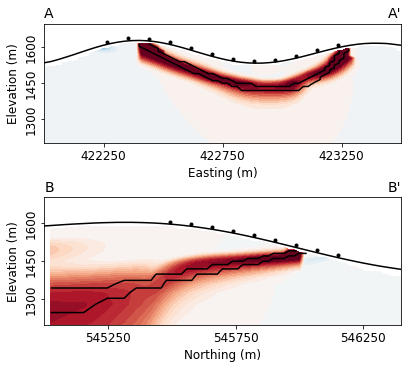

In [420]:
fileName = 'Synthetic_Fold_lpRotated.png'

actvMap = Maps.InjectActiveCells(mesh, actv, -100)
mplot = actvMap * mrec_ROT#IRLS.l2model#(Dz1 * model[actv])#
fig, axs = plt.figure(figsize=(8,6)), plt.subplot(2,1,1)

indy = int(mesh.nCy/2)
xlim = [422000, 423500]
ylim = [1000, 1600]
vmin, vmax = -.05, 0.05

axs, im, cbar = plotModelSections(mesh, mplot, normal='y', ind=indy, cmap='RdBu_r', axs=axs,xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
plotModelSections(mesh, model,normal='y', ind=indy,subFact=4, scale=3., cmap='RdBu_r', contours=[0.05], axs=axs,xlim=[422000,423500], ylim=[1200,1700], fill=False)

plotProfile(topo, [xlim[0],mesh.vectorCCy[int(indy)]], [xlim[1],mesh.vectorCCy[int(indy)]],
                         50, ax=axs, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k')

plotProfile(survey.srcField.rxList[0].locs, [xlim[0],mesh.vectorCCy[int(indy)]], [xlim[1],mesh.vectorCCy[int(indy)]],
                         18, ax=axs, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k.')

cbar.remove()
axs.set_xlabel('Easting (m)', size=12)
x = [422250, 422750, 423250]
axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')

axs.set_ylabel('Elevation (m)', size=12)
x = [1300, 1450, 1600]
axs.set_yticks(list(map(int, x)))
axs.set_yticklabels(map(str, map(int, x)),size=12, rotation=90, va='center')
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0,  pos.width, pos.height])
axs.set_title('A',loc='left', fontsize=14)
axs.set_title("A'",loc='right', fontsize=14)

axs = plt.subplot(2,1,2)

indy = int(mesh.nCx/2)
xlim = [545000, 546400]
ylim = [1000, 1600]
vmin, vmax = -.05, 0.05

axs, im, cbar = plotModelSections(mesh, mplot, normal='x', ind=indy, cmap='RdBu_r', axs=axs,xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
plotModelSections(mesh, model,normal='x', ind=indy,subFact=4, scale=3., cmap='RdBu_r', contours=[0.05], axs=axs,xlim=[422000,423500], ylim=[1200,1700], fill=False)

plotProfile(topo, [mesh.vectorCCx[int(indy)],xlim[0]], [mesh.vectorCCx[int(indy)],xlim[1]],
                         50, ax=axs, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k')

plotProfile(survey.srcField.rxList[0].locs, [mesh.vectorCCx[int(indy)],xlim[0]], [mesh.vectorCCx[int(indy)],xlim[1]],
                         18, ax=axs, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k.')

cbar.remove()
axs.set_xlabel('Northing (m)', size=12)
x = [545250, 545750, 546250]
axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')

axs.set_ylabel('Elevation (m)', size=12)
x = [1300, 1450, 1600]
axs.set_yticks(list(map(int, x)))
axs.set_yticklabels(map(str, map(int, x)),size=12, rotation=90, va='center')
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0,  pos.width, pos.height])
axs.set_title('B',loc='left', fontsize=14)
axs.set_title("B'",loc='right', fontsize=14)

# axbar = plt.axes([pos.x0+0.15, pos.y0,  pos.width*.75, pos.height*.75])
# cbar = plt.colorbar(im, orientation='horizontal',format='%.3f')
# cbar.set_ticks(np.linspace(vmin,vmax,5))
# axbar.text(pos.x0+0.9, pos.y0-.45,'SI', size=14)
# axbar.axis('off')

fig.savefig(work_dir + fileName)

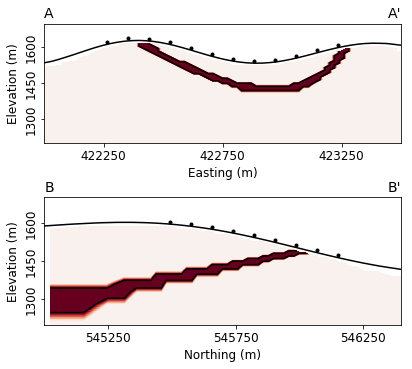

In [422]:
fileName = 'Synthetic_Fold_Model.png'

actvMap = Maps.InjectActiveCells(mesh, actv, -100)
mplot = model#IRLS.l2model#(Dz1 * model[actv])#
fig, axs = plt.figure(figsize=(8,6)), plt.subplot(2,1,1)

indy = int(mesh.nCy/2)
xlim = [422000, 423500]
ylim = [1000, 1600]
vmin, vmax = -.05, 0.05

axs, im, cbar = plotModelSections(mesh, mplot, normal='y', ind=indy, cmap='RdBu_r', axs=axs,xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
plotModelSections(mesh, model,normal='y', ind=indy,subFact=4, scale=3., cmap='RdBu_r', contours=[0.05], axs=axs,xlim=[422000,423500], ylim=[1200,1700], fill=False)

plotProfile(topo, [xlim[0],mesh.vectorCCy[int(indy)]], [xlim[1],mesh.vectorCCy[int(indy)]],
                         50, ax=axs, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k')

plotProfile(survey.srcField.rxList[0].locs, [xlim[0],mesh.vectorCCy[int(indy)]], [xlim[1],mesh.vectorCCy[int(indy)]],
                         18, ax=axs, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k.')

cbar.remove()
axs.set_xlabel('Easting (m)', size=12)
x = [422250, 422750, 423250]
axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')

axs.set_ylabel('Elevation (m)', size=12)
x = [1300, 1450, 1600]
axs.set_yticks(list(map(int, x)))
axs.set_yticklabels(map(str, map(int, x)),size=12, rotation=90, va='center')
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0,  pos.width, pos.height])
axs.set_title('A',loc='left', fontsize=14)
axs.set_title("A'",loc='right', fontsize=14)

axs = plt.subplot(2,1,2)

indy = int(mesh.nCx/2)
xlim = [545000, 546400]
ylim = [1000, 1600]
vmin, vmax = -.05, 0.05

axs, im, cbar = plotModelSections(mesh, mplot, normal='x', ind=indy, cmap='RdBu_r', axs=axs,xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
plotModelSections(mesh, model,normal='x', ind=indy,subFact=4, scale=3., cmap='RdBu_r', contours=[0.05], axs=axs,xlim=[422000,423500], ylim=[1200,1700], fill=False)

plotProfile(topo, [mesh.vectorCCx[int(indy)],xlim[0]], [mesh.vectorCCx[int(indy)],xlim[1]],
                         50, ax=axs, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k')

plotProfile(survey.srcField.rxList[0].locs, [mesh.vectorCCx[int(indy)],xlim[0]], [mesh.vectorCCx[int(indy)],xlim[1]],
                         18, ax=axs, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k.')

cbar.remove()
axs.set_xlabel('Northing (m)', size=12)
x = [545250, 545750, 546250]
axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')

axs.set_ylabel('Elevation (m)', size=12)
x = [1300, 1450, 1600]
axs.set_yticks(list(map(int, x)))
axs.set_yticklabels(map(str, map(int, x)),size=12, rotation=90, va='center')
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0,  pos.width, pos.height])
axs.set_title('B',loc='left', fontsize=14)
axs.set_title("B'",loc='right', fontsize=14)

# axbar = plt.axes([pos.x0+0.15, pos.y0,  pos.width*.75, pos.height*.75])
# cbar = plt.colorbar(im, orientation='horizontal',format='%.3f')
# cbar.set_ticks(np.linspace(vmin,vmax,5))
# axbar.text(pos.x0+0.9, pos.y0-.45,'SI', size=14)
# axbar.axis('off')

fig.savefig(work_dir + fileName)

In [380]:
import matplotlib.gridspec as gridspec

def plotModelSections(mesh, m, normal='x', ind=0, vmin=None, vmax=None,
                      subFact=2, scale=1., xlim=None, ylim=None, vec='k',
                      title=None, axs=None, ndv=-100, contours=None, fill=True,
                      orientation='vertical', cmap='pink_r'):

    """
    Plot section through a 3D tensor model
    """
    # plot recovered model
    nC = mesh.nC

    if vmin is None:
        vmin = m.min()

    if vmax is None:
        vmax = m.max()

    if len(m) == 3*nC:
        m_lpx = m[0:nC]
        m_lpy = m[nC:2*nC]
        m_lpz = -m[2*nC:]

        m_lpx[m_lpx == ndv] = np.nan
        m_lpy[m_lpy == ndv] = np.nan
        m_lpz[m_lpz == ndv] = np.nan

        amp = np.sqrt(m_lpx**2. + m_lpy**2. + m_lpz**2.)

        m_lpx = (m_lpx).reshape(mesh.vnC, order='F')
        m_lpy = (m_lpy).reshape(mesh.vnC, order='F')
        m_lpz = (m_lpz).reshape(mesh.vnC, order='F')
        amp = amp.reshape(mesh.vnC, order='F')
    else:
        amp = m.reshape(mesh.vnC, order='F')

    xx = mesh.gridCC[:, 0].reshape(mesh.vnC, order="F")
    zz = mesh.gridCC[:, 2].reshape(mesh.vnC, order="F")
    yy = mesh.gridCC[:, 1].reshape(mesh.vnC, order="F")

    if axs is None:
        fig, axs = plt.figure(), plt.subplot()

    if normal == 'x':
        xx = yy[ind, :, :].T
        yy = zz[ind, :, :].T
        model = amp[ind, :, :].T

        if len(m) == 3*nC:
            mx = m_lpy[ind, ::subFact, ::subFact].T
            my = m_lpz[ind, ::subFact, ::subFact].T

    elif normal == 'y':
        xx = xx[:, ind, :].T
        yy = zz[:, ind, :].T
        model = amp[:, ind, :].T

        if len(m) == 3*nC:
            mx = m_lpx[::subFact, ind, ::subFact].T
            my = m_lpz[::subFact, ind, ::subFact].T

    elif normal == 'z':
        
        actIndFull = np.zeros(mesh.nC, dtype=bool)
        actIndFull[actv] = True

        actIndFull = actIndFull.reshape(mesh.vnC, order='F')

        model = np.zeros((mesh.nCx,mesh.nCy))
        mx = np.zeros((mesh.nCx,mesh.nCy))
        my = np.zeros((mesh.nCx,mesh.nCy))
        for ii in range(mesh.nCx):
            for jj in range(mesh.nCy):

                zcol = actIndFull[ii, jj, :]
                model[ii, jj] = amp[ii, jj, np.where(zcol)[0][-ind]]
                
                if len(m) == 3*nC:
                    mx[ii, jj] = m_lpx[ii, jj, np.where(zcol)[0][-ind]]
                    my[ii, jj] = m_lpy[ii, jj, np.where(zcol)[0][-ind]]

        xx = xx[:, :, ind].T
        yy = yy[:, :, ind].T
        model = model.T

        if len(m) == 3*nC:
            mx = mx[::subFact, ::subFact].T
            my = my[::subFact, ::subFact].T

    im2, cbar =[], []
    if fill:
        im2 = axs.contourf(xx, yy, model,
                           30, vmin=vmin, vmax=vmax, clim=[vmin, vmax],
                           cmap=cmap)

        cbar = plt.colorbar(im2, orientation=orientation, ax=axs,
                 ticks=np.linspace(im2.vmin, im2.vmax, 4),
                 format="${%.3f}$", shrink=0.5)
    if contours is not None:
        axs.contour(xx, yy, model, contours, colors='k')

    if len(m) == 3*nC:

#         pos = mkvc(mx**2.+my**2.) > 0.
        
        axs.quiver(mkvc(xx[::subFact, ::subFact]),
                   mkvc(yy[::subFact, ::subFact]),
                   mkvc(mx),
                   mkvc(my),
                   pivot='mid',
                   scale_units="inches", scale=scale, linewidths=(1,),
                   edgecolors=(vec),
                   headaxislength=0.1, headwidth=10, headlength=30)
    

    axs.set_aspect('equal')

    if xlim is not None:
        axs.set_xlim(xlim[0], xlim[1])

    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])

    if title is not None:
        axs.set_title(title)

    
    return axs, im2, cbar

def vizCond(mesh, model, axs=None, normal = 'z', ind = 0, xlim=None, ylim=None, vmin=None, contours=None, fill=True, vmax=None,subFact=None, scale=1., savefig=False, cmap = 'jet_r', figname="Conductivity.png"):

    
    axs, im, cbar = plotModelSections(mesh, model, normal=normal,
                               ind=ind, axs=axs, cmap=cmap, subFact=subFact,
                               xlim=xlim, scale = scale, vec ='w',
                               ylim=ylim, contours=contours, fill=fill,
                               vmin=vmin, vmax=vmax)

        
    
    

    if normal=='x':
        axs.set_title(str(int(mesh.vectorCCx[ind])) + ' E')
        # Add lakes and hydro
#         for file in pline[:11]:
#             trace = np.loadtxt(file, skiprows=1, delimiter=',')
#             ax2.plot(trace[:,1], trace[:,2], 'k', ms=1)
#             ax2.text(trace[0,1], trace[0,2],file[28:-4])
        
    elif normal=='y':
        axs.set_title(str(int(mesh.vectorCCy[ind])) + ' N')
        # Add lakes and hydro
#         for file in pline[11:]:
#             trace = np.loadtxt(file, skiprows=1, delimiter=',')
#             ax2.plot(trace[:,0], trace[:,2], 'k', ms=1)
#             ax2.text(trace[0,0], trace[0,2],file[28:-4])
            
    else:
        axs.set_title('Depth: -' + str(np.sum(mesh.hz[-ind:-1])+mesh.hz[-ind]/2) + ' m')
        
    return axs, im, cbar

from scipy.interpolate import griddata

def plotProfile(xyzd, a, b, npts, data=None,
                fig=None, ax=None, plotStr='b.-',
                coordinate_system='local'):
    """
    Plot the data and line profile inside the spcified limits
    """
    def linefun(x1, x2, y1, y2, nx, tol=1e-3):
        dx = x2-x1
        dy = y2-y1

        if np.abs(dx) <= tol:
            y = np.linspace(y1, y2, nx)
            x = np.ones_like(y)*x1
        elif np.abs(dy) <= tol:
            x = np.linspace(x1, x2, nx)
            y = np.ones_like(x)*y1
        else:
            x = np.linspace(x1, x2, nx)
            slope = (y2-y1)/(x2-x1)
            y = slope*(x-x1)+y1
        return x, y

    if fig is None:
        fig = plt.figure(figsize=(6, 9))

        plt.rcParams.update({'font.size': 14})

    if ax is None:
        ax = plt.subplot()

    x, y = linefun(a[0], b[0], a[1], b[1], npts)
    distance = np.sqrt((x-a[0])**2.+(y-a[1])**2.)
    dline = griddata(xyzd[:, :2], xyzd[:, -1], (x, y), method='linear')

    if coordinate_system == 'xProfile':
        distance += a[0]
    elif coordinate_system == 'yProfile':
        distance += a[1]

    ax.plot(distance, dline, plotStr)

    if data is not None:
        dline = griddata(xyzd[:, :2], data, (x, y), method='linear')
        ax.plot(distance, dline, 'r.-')

    ax.set_xlim(distance.min(), distance.max())

    # ax.set_xlabel("Distance (m)")
    # ax.set_ylabel("Magnetic field (nT)")

    #ax.text(distance.min(), dline.max()*0.8, 'A', fontsize = 16)
    # ax.text(distance.max()*0.97, out_linei.max()*0.8, 'B', fontsize = 16)
    # ax.legend(("Observed", "Simulated"), bbox_to_anchor=(0.5, -0.3))
    # ax.grid(True)

    return ax

In [381]:
from ipywidgets import widgets
def ModSlicer(mesh, model, figName, cmap='jet', contours=None, subFact=1):

    xc = np.mean(mesh.vectorCCx)
    yc = np.mean(mesh.vectorCCy)
    zc = np.mean(mesh.vectorCCz)
    
    model[model==ndv] = np.nan
    model = mkvc(model)
    vmin = 0
    def plotIt(Lx, Ly, Lz, indx, indy, indz, vecScale, vmax):


        
        fig = plt.figure(figsize=(14, 8))
        ax1 = plt.subplot(2,2,4)
        x1lim = [xc-Lx,xc+Lx]
        y1lim = [zc-Lz,zc+Lz]



        ax1, im, cbar = vizCond(mesh, model, axs=ax1, normal = 'y', scale=vecScale, contours=contours, ind = int(indy), xlim=x1lim, ylim=y1lim, subFact=subFact, vmin=vmin, vmax=vmax, cmap = cmap)
        plotProfile(topo, [x1lim[0],mesh.vectorCCy[int(indy)]], [x1lim[1],mesh.vectorCCy[int(indy)]],
                         50, ax=ax1, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k')
        pos = ax1.get_position()
        ax1.set_position([pos.x0, pos.y0+0.04,  pos.width, pos.height])
        cbar.remove()
        ax1.set_ylabel('Elevation (masl)')
        ax1.set_xlabel('Easting (m)')
#         x = [596600, 597600, 598600]
#         ax1.set_xticks(list(map(int, x)))
#         ax1.set_xticklabels(map(str, map(int, x)),size=12)
#         x = [-100, 400, 900]
#         ax1.set_yticks(list(map(int, x)))
#         ax1.set_yticklabels(map(str, map(int, x)),size=12, rotation=90, va='center')
#         ax1.text(596300,-200,'b', color='k', size=16)
#         ax1.set_title("")

        ax3 = plt.subplot(2,2,2)
        x3lim = [yc-Ly,yc+Ly]
        y3lim = [zc-Lz,zc+Lz]
        ax3, im, cbar = vizCond(mesh, model, axs=ax3, normal = 'x', scale=vecScale, contours=contours, ind = int(indx), xlim=x3lim, ylim=y3lim, subFact=subFact, vmin=vmin, vmax=vmax, cmap = cmap)
        plotProfile(topo, [mesh.vectorCCx[int(indx)],x3lim[0]], [mesh.vectorCCx[int(indx)],x3lim[1]],
                         50, ax=ax3, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k')
        pos = ax3.get_position()
        ax3.set_position([pos.x0, pos.y0-0.025,  pos.width, pos.height])
        ax3.set_ylabel('Elevation (masl)')
        ax3.set_xlabel('Northing (m)')
#         x = [5400000, 5401000, 5402000]
#         ax3.set_xticks(list(map(int, x)))
#         ax3.set_xticklabels(map(str, map(int, x)),size=12)
#         x = [-100, 400, 900]
#         ax3.set_yticks(list(map(int, x)))
#         ax3.set_yticklabels(map(str, map(int, x)),size=12, rotation=90, va='center')
#         ax3.text(5399700,-200,'c', color='k', size=16)
        cbar.remove()
        
        ax2 = plt.subplot(1,2,1)
        xlim = [xc-Lx,xc+Lx]
        ylim = [yc-Ly,yc+Ly]
        ax2, im, cbar = vizCond(mesh, model, axs=ax2, normal = 'z', scale=vecScale, contours=contours, ind = int(indz), xlim=xlim, ylim=ylim, subFact=subFact, vmin=vmin, vmax=vmax, cmap = cmap)
        pos = ax2.get_position()
        cbar.set_label('SI',labelpad=-38, y=1.075, rotation=0)
        ax2.set_ylabel('Northing (m)')
        ax2.set_xlabel('Easting (m)')
        ax2.set_position([pos.x0, pos.y0,  pos.width, pos.height])
#         x = [596600, 597600, 598600]
#         ax2.set_xticks(list(map(int, x)))
#         ax2.set_xticklabels(map(str, map(int, x)),size=12)
#         x = [5400000, 5401000, 5402000]
#         ax2.set_yticks(list(map(int, x)))
#         ax2.set_yticklabels(map(str, map(int, x)),size=12, rotation=90, va='center')

#         ax2.text(596300,5399700,'a', color='k', size=16)
        
        plt.plot(x1lim, [mesh.vectorCCy[int(indy)], mesh.vectorCCy[int(indy)]], c='k')
        plt.plot([mesh.vectorCCx[int(indx)], mesh.vectorCCx[int(indx)]], x3lim, c='k')
        plt.show()
        
        fig.savefig(figName)
        
    out = widgets.interactive(plotIt,
                              Lx = widgets.FloatSlider(min=0, max=np.sum(mesh.hx)/2, step=10,value=np.sum(mesh.hx)/2, continuous_update=False),
                              Ly = widgets.FloatSlider(min=0, max=np.sum(mesh.hy)/2, step=10,value=np.sum(mesh.hy)/2, continuous_update=False),
                              Lz = widgets.FloatSlider(min=0, max=np.sum(mesh.hz)/2, step=10,value=np.sum(mesh.hz)/2, continuous_update=False),
                              indx = widgets.FloatSlider(min=0, max=mesh.vnC[0], step=1,value=int(mesh.vnC[0]/2), continuous_update=False),
                              indy = widgets.FloatSlider(min=0, max=mesh.vnC[1], step=1,value=int(mesh.vnC[1]/2), continuous_update=False),
                              indz = widgets.FloatSlider(min=1, max=mesh.vnC[2], step=1,value=1, continuous_update=False),
                              vecScale = widgets.FloatSlider(min=0, max=10, step=0.1,value=1, continuous_update=False),  
                              vmax = widgets.FloatSlider(min=0, max=1, step=0.001,value=0.1, continuous_update=False)  

                             )
    
    

    return out

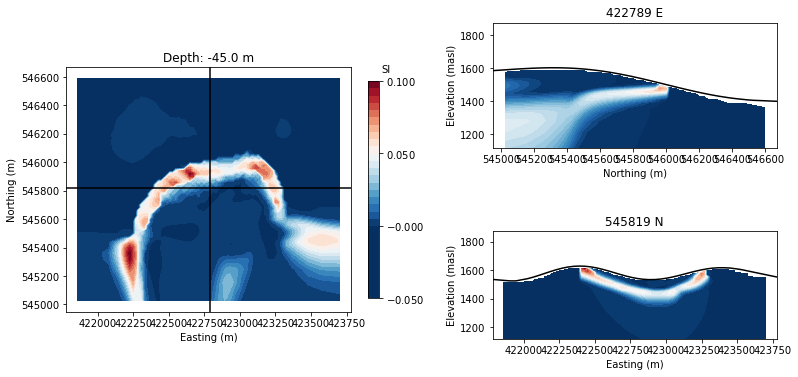

In [383]:
m = np.ones(mesh.nC)*-100
temp = actvMap *IRLS.l2model
m[surf] = temp[surf]

ModSlicer(mesh, actvMap *mrec_ROT, work_dir + 'ModelRec.png', cmap='RdBu_r', subFact=3)
